# Clustering Analysis
During our regression analysis, we found that using linear regression for inference was no good. The residual plot we obtained from our regression analysis was not evenly distributed around 0. In addition, a pattern can be observed on the residual as the value of the predicted value increases. In this notebook, we will postpone our modelling activities for a while. We will dive deeper into our data to find more interesting patterns that might help us in the future in deciding which modelling techniques to use understanding the impact of our predictor variables with the premium charges.

To explore our data further, we will utilize unsupervised learning techniques such K-Means to find more interesting patterns in our data that might give us more light during our modelling.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
DATASET_URI = "dataset/insurance.csv"
df0 = pd.read_csv(DATASET_URI)

## Feature Transformation

In [3]:
# Engineer Features
df0["log-charges"] = np.log1p(df0["charges"])
df0.drop(["charges"], axis=1, inplace=True)

df0.sample(n=10)

age     sex     bmi  children smoker     region  log-charges
99     38    male  19.300         0    yes  southwest     9.669138
988    34    male  34.675         0     no  northeast     8.416229
1140   50    male  37.070         1     no  southeast     9.110413
1132   57    male  40.280         0     no  northeast     9.938373
490    19  female  32.900         0     no  southwest     7.467242
1054   27  female  21.470         0     no  northwest     8.118049
14     27    male  42.130         0    yes  southeast    10.586907
1279   25  female  26.790         2     no  northwest     8.340483
216    53  female  26.600         0     no  northwest     9.245383
341    62    male  30.020         0     no  northwest     9.499504

In [4]:
df1 = pd.get_dummies(df0, drop_first=True)

## Data Visualization
Let's visualize the distribution of the numerical predictors with the response variables.

In [5]:
sns.set_style("whitegrid")

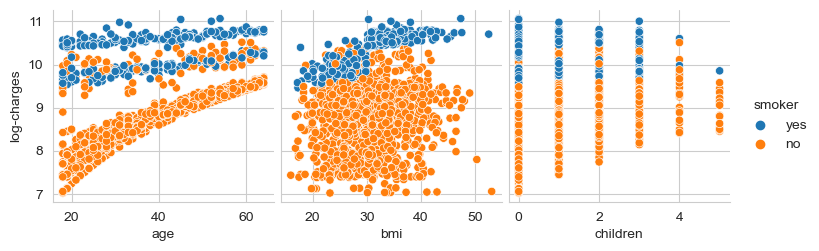

In [6]:
sns.pairplot(
    df0,
    kind="scatter",
    hue="smoker",
    x_vars=["age", "bmi", "children"],
    y_vars=["log-charges"],
);

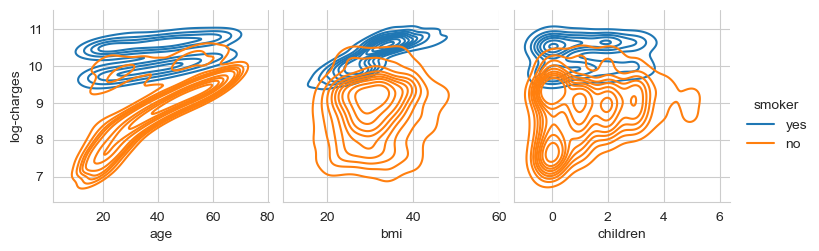

In [7]:
sns.pairplot(
    df0,
    kind="kde",
    hue="smoker",
    x_vars=["age", "bmi", "children"],
    y_vars=["log-charges"]
);

Based on the above results, the relationship of `age`, `bmi`, and `children` with `log-charges` is not linear. Using the bivariate kernel density plot, we can observe that there were several clusters present on our dataset. Let's examine our dataset further if we can find subgroups/clusters. One way we could do this is using `FacetGrid` of seaborn.
Using this chart, we can visualize more than two variables.

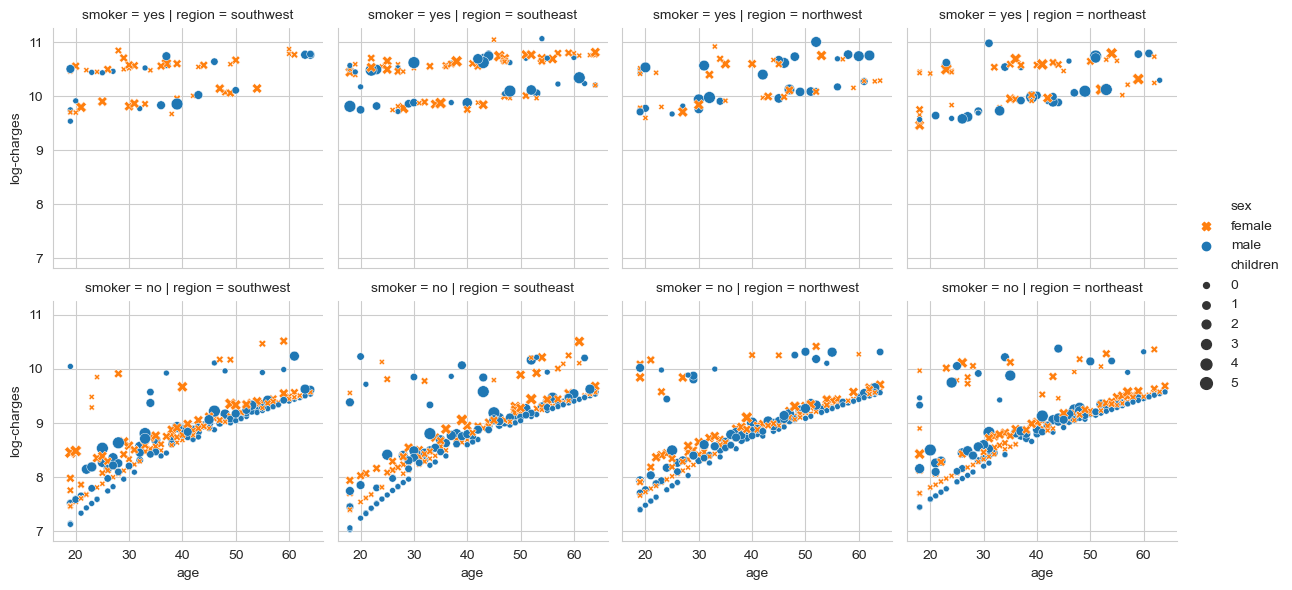

In [8]:
g = sns.FacetGrid(df0, col="region",  row="smoker")
g.map(sns.scatterplot, "age", "log-charges", "sex", "children", "sex");
g.add_legend()

On the above visualization, we plotted the scatterplot of age and log-charges. We can observe that the shape of the distribution of smokers and non-smokers were different! The scatterplot of smokers contains two clusters with a pattern similar to that of a line. On the same manner, the scatterplot of non-smokers also contains two clusters. However, one its cluster appears to be a quadratic line while the other appears to be a straight line with some noise.

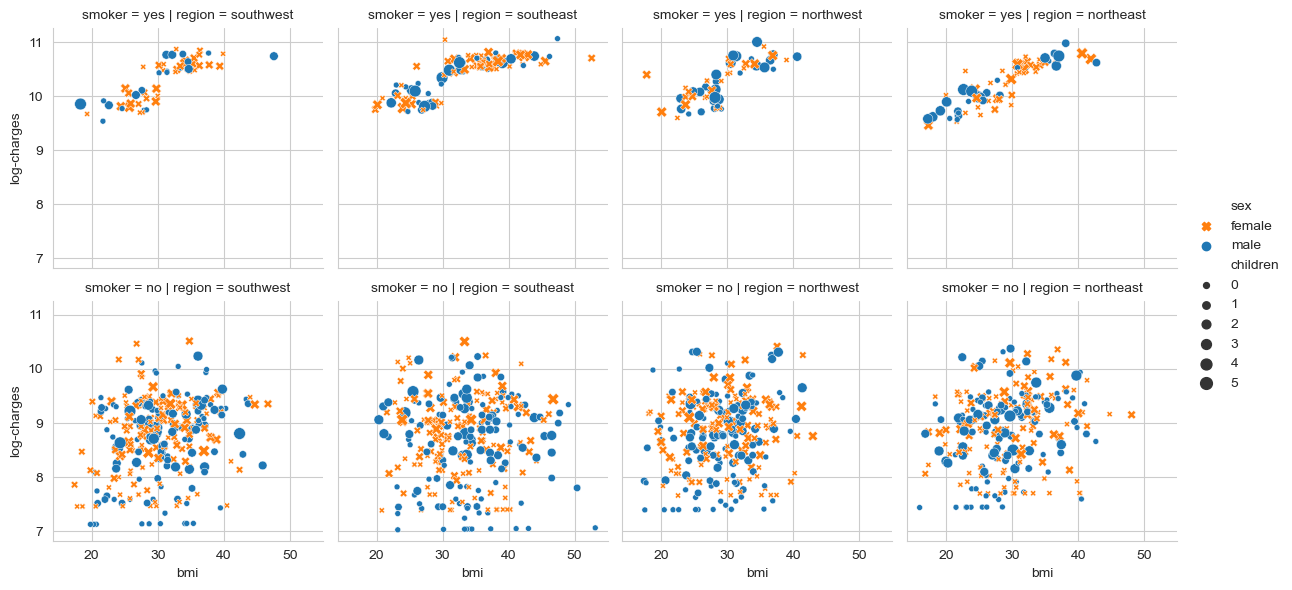

In [9]:
g = sns.FacetGrid(df0, col="region",  row="smoker")
g.map(sns.scatterplot, "bmi", "log-charges", "sex", "children", "sex");
g.add_legend()

The above visualization shows the scatter plot of `bmi` with `log-charges`. On the above plot, we can observe that the distribution of non-smokers and smokers were very different. The scatterplot of smokers appears to be a straight line whereas for the non-smoker, no pattern can be observed.

Based on our observations from our exploratory data analysis, we cannot proceed yet with linear regression modelling. There were no direct linear relationship between our numerical variables. In addition, we observed presence of subgroups in our scatter plots. Before conducting a regression analysis, let's cluster our dataset using unsupervised machine learning. Once clustered, we will conduct separate regression analysis on each cluster.

## Clustering
During our data visualization, we observed that there were 6-different clusters of data. To make a more accurate clustering, we can use K-Means clustering algorithm instead.

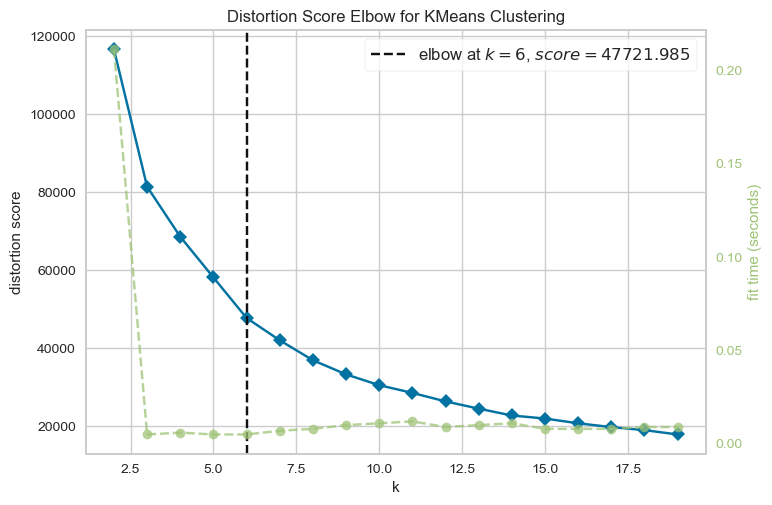

In [10]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

elbow_visualizer = KElbowVisualizer(KMeans(random_state=22), k=(2,20))
elbow_visualizer.fit(df1)
elbow_visualizer.show();

The above visualization shows the amount of distortion score as the number of cluster increases. Based on the above plot, the optimal number of cluster for our dataset was 6. Surprisingly, this finding was the same with our observations from our data visualization.

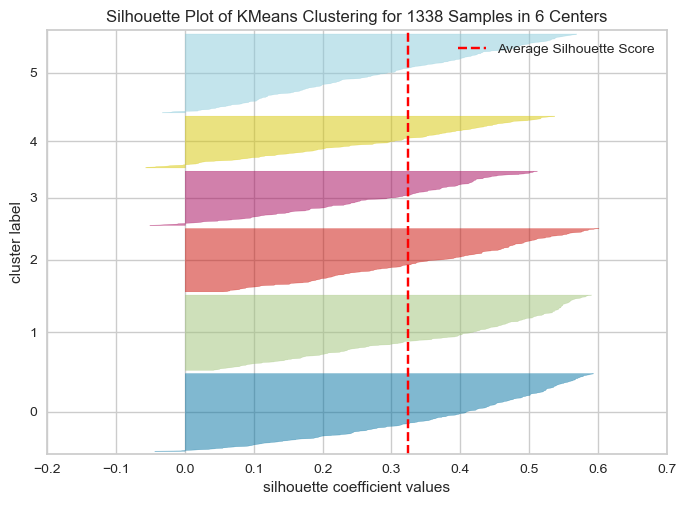

In [11]:
from yellowbrick.cluster import SilhouetteVisualizer

silhouette_visualizer = SilhouetteVisualizer(KMeans(elbow_visualizer.elbow_value_, random_state=22), colors='yellowbrick')
silhouette_visualizer.fit(df1)
silhouette_visualizer.show();

Above silhouette plot shows that all of the 6 clusters had an above average silhouette scores. This means that our dataset can be clustered into 6 different groups.

### Cluster the Dataframe

In [12]:
clusterer = KMeans(n_clusters=elbow_visualizer.elbow_value_, random_state=42)

clusterer.fit(df1)

KMeans(n_clusters=6, random_state=42)

In [13]:
df0["cluster"] = clusterer.labels_
df0.sample(10)

age     sex     bmi  children smoker     region  log-charges  cluster
428    21  female  16.815         1     no  northeast     8.061000        1
16     52  female  30.780         1     no  northeast     9.287147        0
503    19    male  30.250         0    yes  southeast    10.390512        1
268    45    male  30.200         1     no  southwest     8.914902        0
905    26  female  29.355         2     no  northeast     8.426216        1
521    32  female  44.220         0     no  southeast     8.292843        5
1034   61    male  38.380         0     no  northwest     9.468934        2
759    18    male  38.170         0    yes  southeast    10.499815        5
416    52    male  34.100         0     no  southeast     9.120629        2
1112   48  female  25.850         3    yes  southeast    10.093361        0

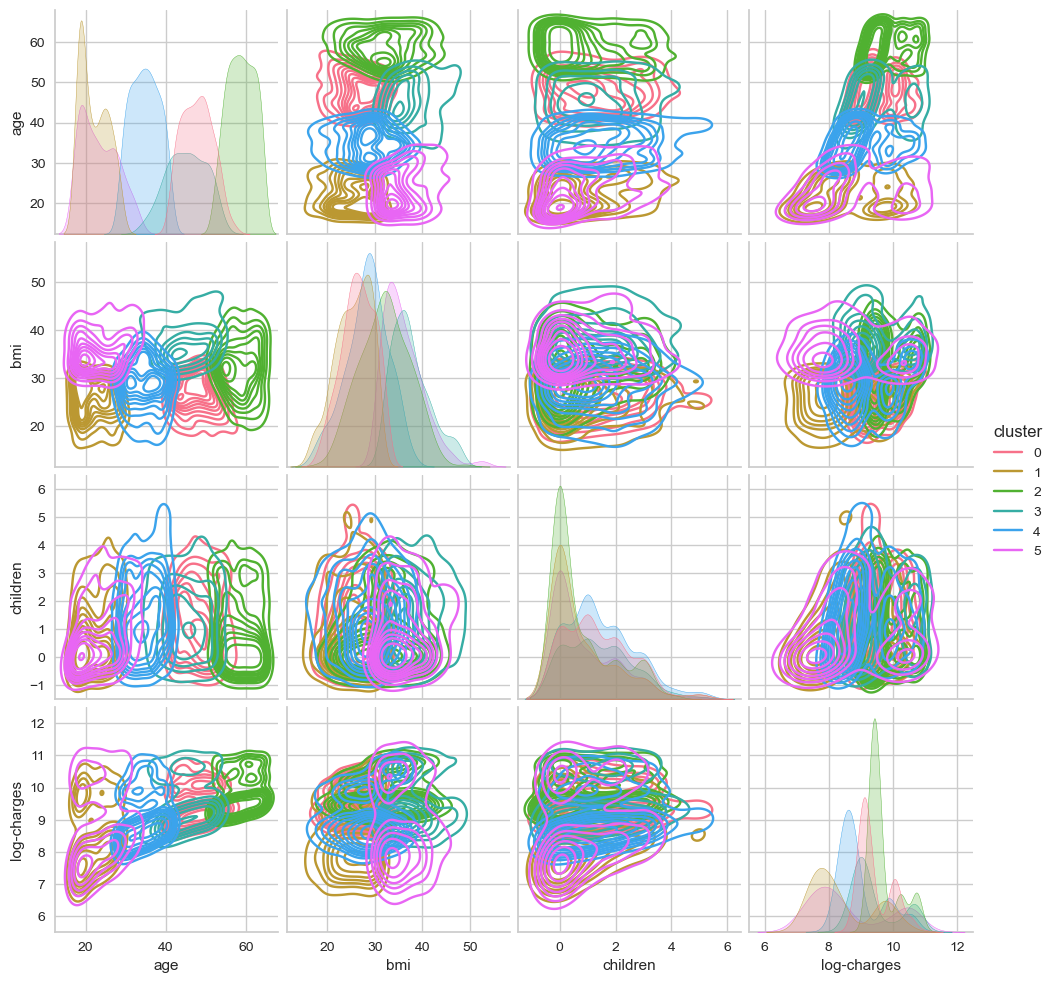

In [14]:
sns.pairplot(
    df0,
    kind="kde",
    hue="cluster",
    palette=sns.color_palette("husl", elbow_visualizer.elbow_value_),
);

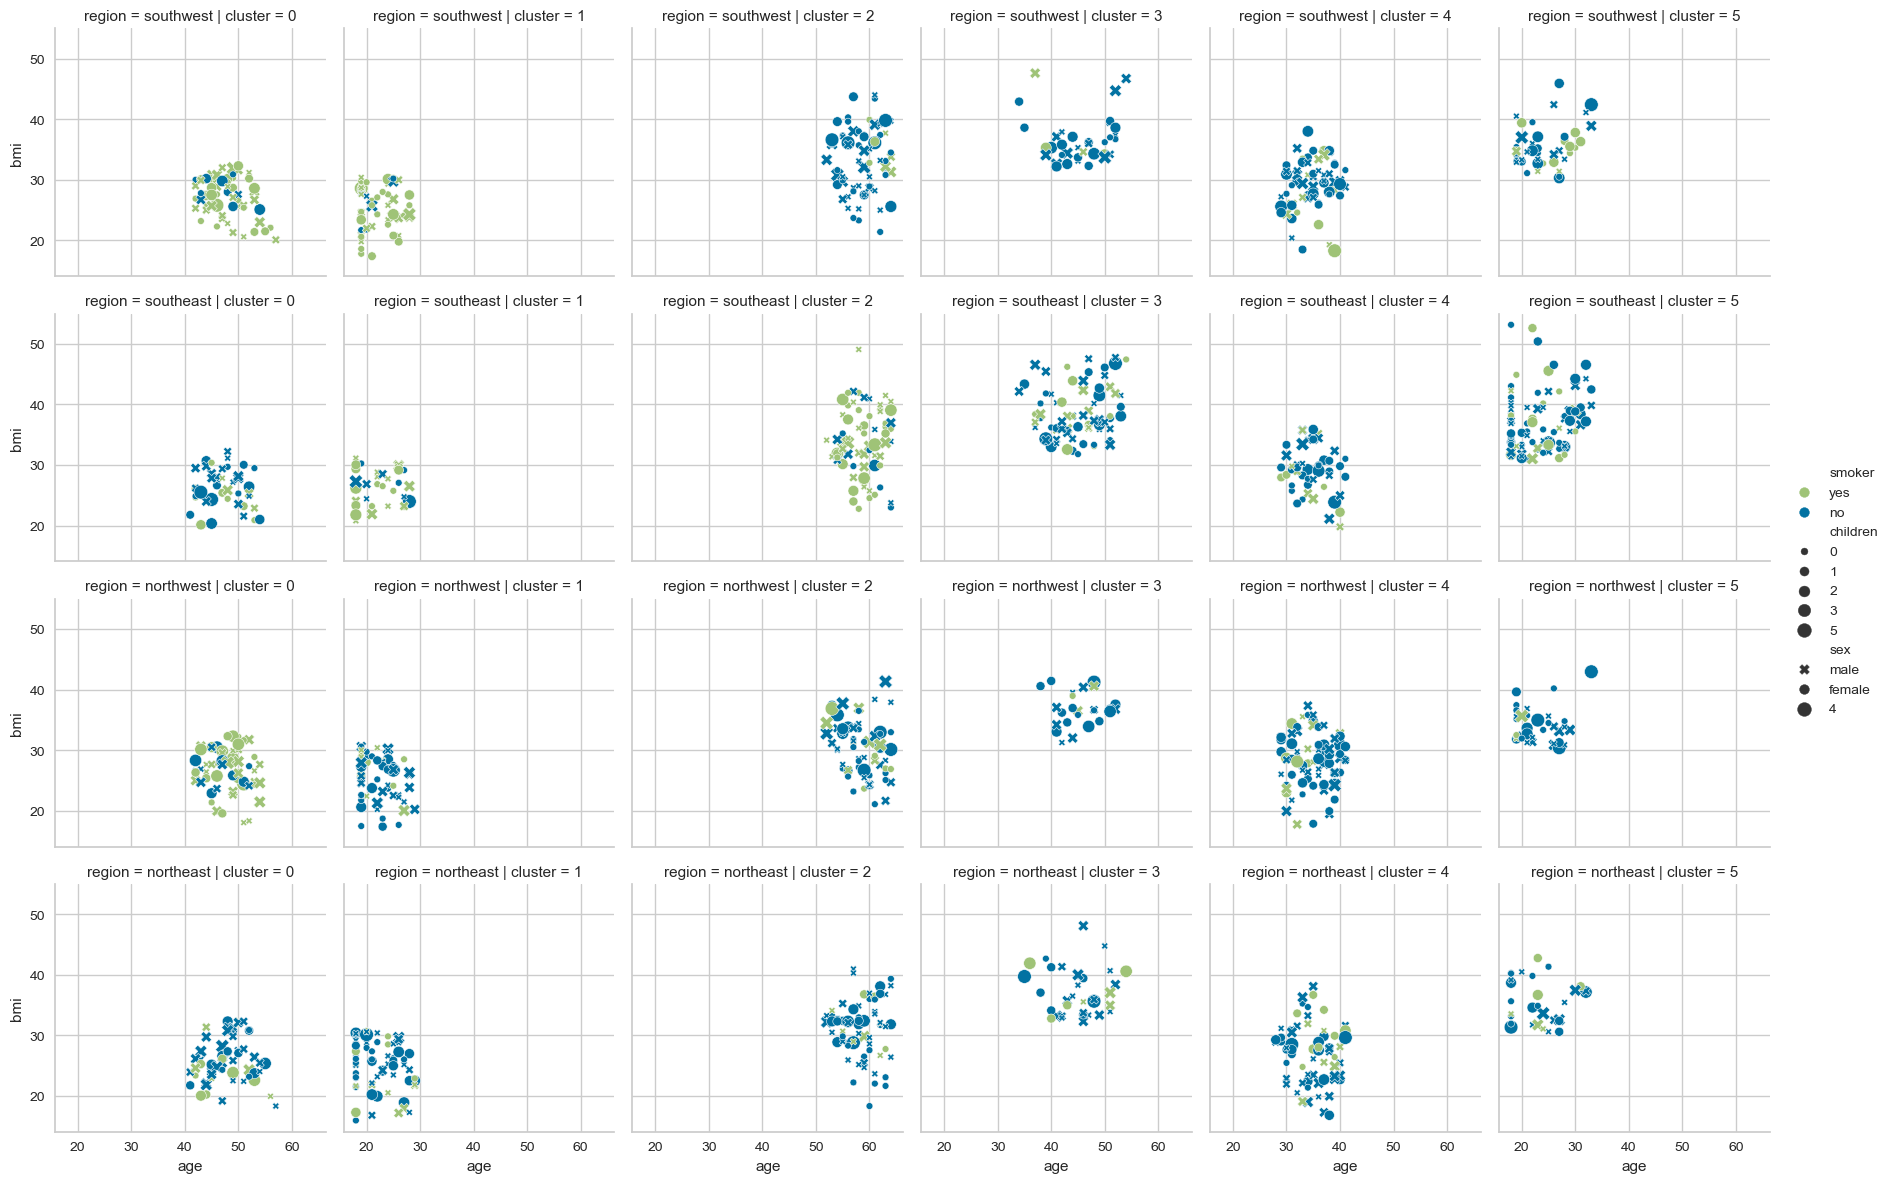

In [15]:
g = sns.FacetGrid(df0, col="cluster",  row="region")
g.map(sns.scatterplot, "age", "bmi", "smoker", "children", "sex");
g.add_legend();